# Практика №2

На прошлой практике мы реализовали DTW алгоритм. Он очень хорош и вроде как даже где-то применяется. Но у него есть существенные недостатки:

1) Для распознавания какого-либо слова необходимо иметь заранее подготовленные эталонные записи. Из этого вытекает проблема масштабирования системы с большим словарем.<br>
2) Подобная система имеет плохую устойчивость к шумам.<br>
3) По какому принципу вибирать нужные эталоны?<br>
4) Сколько должно быть таких эталонов, чтобы покрыть всю вариативность произнесеней?<br>
5) Чем больше эталонов, тем алгоритм вычислительнозатратен.<br>

В этом уроке мы перейдем от DTW к распознаванию по эталонному словарю. 

Эталон в графе теперь будет задаваться как последовательность фонем из словаря. Словарь для YES_NO (data/lexicon_yes_no.txt) выглядит следующим образом:

<b>YES</b>  SIL Y EH1 S SIL<br>
<b>NO</b>  SIL N OW1 SIL<br>

Словарь для цифр (data/lexicon_digits.txt):

<b>ZERO</b>  SIL Z IH1 R OW0 SIL<br>
<b>ZERO</b>  SIL Z IY1 R OW0 SIL<br>
<b>ONE</b>  SIL W AH1 N SIL<br>
<b>ONE</b>  SIL HH W AH1 N SIL<br>
<b>TWO</b>  SIL T UW1 SIL<br>
<b>THREE</b>  SIL TH R IY1 SIL<br>
<b>FOUR</b>  SIL F AO1 R SIL<br>
<b>FIVE</b>  SIL F AY1 V SIL<br>
<b>SIX</b>  SIL S IH1 K S SIL<br>
<b>SEVEN</b>  SIL S EH1 V AH0 N SIL<br>
<b>EIGHT</b>  SIL EY1 T SIL<br>
<b>NINE</b>  SIL N AY1 N SIL<br>

SIL здесь – это фонема паузы.
Как вы возможно заметили, для некторых слов имеется несколько вариантов фонемной транскрипции. Это позволяет лучше учесть фонетическое разнообразие в произнесении некоторых слов.

Каждой фонеме будет сопоставлен наиболее типичный для нее вектор признаков. В данном случае мы будем использовать среднее значение вектора признаков фонем, взятых из обучающего набора. Будем называть это акустической моделью.

### Данные для обучения

Наша задача собрать статистику акустических признаков по каждой фонеме, находящейся в графе распознавания. В качестве обучающей выборки мы будем использовать подмножество данных librispeech (аудиозаписи чтения книг на английском). Для этого предварительно мной была получена покадровая разметка этого подмножества на фонемы. Схематично данный процесс представлен на картинке ниже:

![](https://drive.google.com/uc?export=view&id=16PdwggV_Cl6aaD4cu1MZ-fKzWzAvcFVw)

Файл разметки (ali_phones.txt) представлен в формате:

<b>filename1 phone_frame1 phone_frame2 phone_frame3 ...<br>
   filename2 phone_frame1 phone_frame2 phone_frame3 ...</b> 
   
Пример такой покадровой фонемной разметки одного файла с текстом "<b>MUCH COULD BE DONE IN THREE YEARS</b>" представлен ниже:

<b>1183-124566-0003 SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL M M M M M M M M M AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 CH CH CH CH CH CH CH CH CH CH CH K K K K
K K K K K UH1 UH1 UH1 UH1 D D D D D B B B B B B IY0 IY0 IY0 IY0 IY0 D D D D D D D D D D D D AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 N N
N N N N N N N N N N N N N SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SI
L SIL SIL SIL SIL SIL SIL SIL SIL IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 N N N N N N N N N N SIL SIL SIL SIL SIL TH TH TH TH TH TH TH TH TH TH TH TH TH R R R R R R IY1 IY1
 IY1 IY1 IY1 IY1 IY1 Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 R R R R R R R R R R R R R R R Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z SIL SIL SIL SIL</b>
 
Аудио файлы этих данных лежат в папке "data/train_librispeech_10h/wav_dir"

### Bootstrap

In [1]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 88.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:06<00:00, 105MB/s]


In [2]:
!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv train_librispeech_10h lab2/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab2

/content/lab2


In [3]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# рассмотрим пример такой записи:
wav_example = 'data/train_librispeech_10h/wav_dir/1183-124566-0003.flac'

# чтение wav файла:
x, sr = librosa.load(wav_example, sr=None)     # sr=None to preserve the native sampling rate

print(f'Number of samples: {len(x)}')
print(f'Sampling rate: {sr} Hz')
print(f'Duration: {len(x)/sr:.2f} s')  # ~ librosa.get_duration(x, sr)

# воспроизведение:
ipd.Audio(x, rate=sr)

Number of samples: 45680
Sampling rate: 16000 Hz
Duration: 2.85 s


Text(0.5, 1.0, 'Log-frequency power spectrogram')

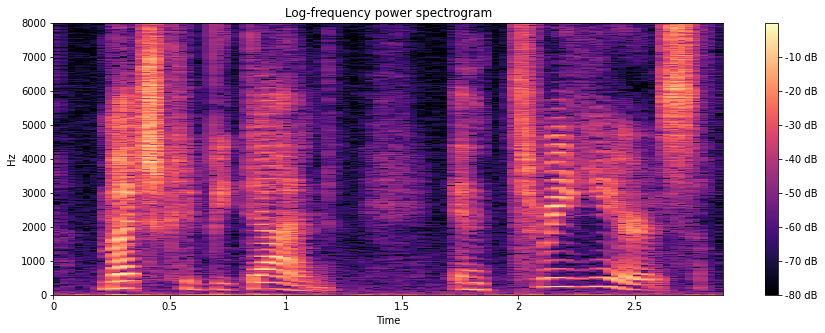

In [5]:
# спектрограмма:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
plt.figure(figsize=(15,5))
librosa.display.specshow(D, sr=sr, y_axis='hz', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

### Подготовка данных

In [6]:
# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

In [7]:
# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    for step, wav_name in tqdm(enumerate(os.listdir(dir_path))):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict

train_records_dir = 'data/train_librispeech_10h/wav_dir'
train_data_dict = load_data_dict(train_records_dir, count=100)

0it [00:00, ?it/s]

Early stop at 100th file..


In [8]:
# инициализация списка допустимых фонем из предустановленного файла
def init_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for line in fn:
            phones_dict[line.strip()] = []
    return phones_dict

phones_file = 'data/train_librispeech_10h/phones'
phones_dict = init_phones_dict(phones_file)

In [9]:
# присвоим каждой фонеме набор ее признаков в соответствии с фонемной разметкой обучающей выборки
# количество кадров признаков может немного отличаться от количества размеченных фонем
# это связано с особенностми построения разметки в Kaldi
for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])
        
# выведем статистику по кадой фонеме (некоторые фонемы вообще не используются, это особенности разметки в Kaldi):
count = 0
for phone in phones_dict.keys():
    if len(phones_dict[phone]) == 0:
        count +=1
    print(f'{phone:<3}: {len(phones_dict[phone])}')
print(f'Number of empty phones is: {count}')

SIL: 23073
SPN: 955
AA : 0
AA0: 36
AA1: 1551
AA2: 91
AE : 0
AE0: 38
AE1: 3343
AE2: 73
AH : 0
AH0: 5196
AH1: 1665
AH2: 54
AO : 0
AO0: 16
AO1: 1605
AO2: 53
AW : 0
AW0: 0
AW1: 1206
AW2: 69
AY : 0
AY0: 12
AY1: 3370
AY2: 156
B  : 1569
CH : 944
D  : 3601
DH : 2010
EH : 0
EH0: 36
EH1: 2726
EH2: 79
ER : 0
ER0: 2363
ER1: 868
ER2: 9
EY : 0
EY0: 13
EY1: 2501
EY2: 107
F  : 2232
G  : 728
HH : 2160
IH : 0
IH0: 2683
IH1: 2185
IH2: 106
IY : 0
IY0: 2207
IY1: 2290
IY2: 48
JH : 625
K  : 2770
L  : 4089
M  : 2733
N  : 5605
NG : 1458
OW : 0
OW0: 167
OW1: 1875
OW2: 275
OY : 0
OY0: 0
OY1: 331
OY2: 0
P  : 2371
R  : 3733
S  : 6445
SH : 1042
T  : 5861
TH : 756
UH : 0
UH0: 5
UH1: 358
UH2: 7
UW : 0
UW0: 75
UW1: 1223
UW2: 22
V  : 1573
W  : 2190
Y  : 544
Z  : 3307
ZH : 47
Number of empty phones is: 18


In [10]:
# соберем статистику на основе среднего значения для каждой фонемы
mean_phones_value = {}
for phone in phones_dict.keys():
    if phones_dict[phone]:
        mean_phones_value[phone] = np.mean(phones_dict[phone], axis=0)

In [11]:
#-----------------------------TODO №2-----------------------------------
# построить GMM модель для каждой фонемы (смотри задание2)
#-----------------------------------------------------------------------

### Инициализация фонемного графа

In [12]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)

Узлы графа теперь представляют собой отдельные фонемы с переходом только в себя и следующий узел (переходов через несколько узлов уже не будет, так как пропуск фонемы в слове нежелателен). Схема такого графа для да/нет (для цифр по аналогии) представлена ниже:

![](https://drive.google.com/uc?export=view&id=1IJhR0l0YCPDge05ohigs0_P5gDX66fdM)

В качестве <b>model</b> мы будем хранить простой класс <b>AcousticModel</b>, который хранит в себе имя фонемы и ее среднее значение. Также у этого класса есть метод вычисления евклидовой дистанции от хранящегося в нем среднего значения признака фонемы до текущего признака распознаваемой записи, который передается этому методу. 

In [13]:
class AcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats
    def distance(self, input_feats):
        return float(np.sqrt(sum(pow(self.phone_feats - input_feats, 2))))

#-----------------------------TODO №2--------------------------------------------
# заменить акустическую модель на основе среднего значения признака на GMM модель
class GmmAcousticModel:
    def __init__(self, phone_name, phone_feats, covariance_type='full'):
        self.phone_name = phone_name
        if phone_feats is None:
            self.phone_feats = None
        else:
            n_components = 1 if len(phone_feats) == 1 else 3
            self.phone_feats = GaussianMixture(
                n_components=n_components,
                covariance_type=covariance_type,
                random_state=42
            ).fit(phone_feats)
       
    def distance(self, input_feats):
        input_feats = np.asarray(input_feats).reshape(1, -1)
        return -self.phone_feats.score(input_feats) # -Loglikelihood
#--------------------------------------------------------------------------------

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, mean_phones_value):
    start_state = State(AcousticModel(None, None), 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, mean_phones_value[phone]), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

def print_graph(graph):
    if not os.path.exists('exp'):
        os.mkdir('exp')
    with open('exp/graph.txt', 'w') as fn:
        np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write("State: index={} word={} is_final={} next_state_indexes={} phone={} \n".format(
                state.index, state.word, state.is_final, next_state_indexes, state.model.phone_name))
    print("*** SEE exp/graph.txt ***")

In [14]:
graph = load_graph(lexicon_dict, mean_phones_value)
print_graph(graph)

*** SEE exp/graph.txt ***


In [15]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    best_token = next_tokens[np.argmin([token.dist for token in next_tokens])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for token in next_tokens:  
        if not token.state.best_token:
            token.state.best_token = token
        else:
            if token.dist <= token.state.best_token.dist:
                token.state.best_token.alive = False
                token.state.best_token = token
            else:
                token.alive = False              
    # сбрасываем best_token на None для всеx узлов графа:
    for token in next_tokens:                                                   
        if token.state.best_token:                     
            token.state.best_token = None              
    return next_tokens


def recognize(filename, features, graph, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []

    #for ftr_frame in tqdm(features, desc="recognition..."):
    for ftr_frame in features:
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [16]:
def run_recognizer(records_data_dict, graph, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename, records_data_dict[filename], graph, recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

In [17]:
#def load_data_dict(dir_path):
#    data_dict = {}
#    for wav_name in os.listdir(dir_path):
#        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
#        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
#                                    n_fft=int(sr * 0.025),
#                                    hop_length=int(sr * 0.01))
#        data_dict[wav_name] = mfcc.T
#    
#    return data_dict

### Запустим наше распознавание на базе YES_NO

In [18]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=20)

0it [00:00, ?it/s]

result: no_4abb2400_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> NO
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.12 sec
------------------------------------------------------------


### Запустим наше распознавание на базе Digits

In [19]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=2000)

0it [00:00, ?it/s]

result: five_ffd2ba2f_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> ONE
result: five_f852895b_nohash_0      ==> FIVE
result: nine_ccea893d_nohash_0      ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: seven_fe5c4a7a_nohash_0     ==> FIVE
result: three_feb1d305_nohash_0     ==> SIX
result: one_fc2411fe_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> SIX
result: two_fce65496_nohash_0       ==> SEVEN
result: eight_da584bc0_nohash_4     ==> SIX
result: three_fce96bac_nohash_0     ==> FIVE
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_fce65496_nohash_0      ==> ZERO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: nine_fbe51750_nohash_0      ==> NINE
result: eight_daf230ac_nohash_0     ==> SIX
result: zero_f92e49f3_nohash_3      ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> FIVE
------------------------------------------------------------
WER is: 55.00%
Total time is: 1.69 sec
-------

### <b>Задание №1</b> (5 баллов):
Отрисовать кластеры признаков фонем "Y EH1 S N OW1" в двухмерном пространстве. Для понижения размерности можно воспользоваться алгоритмом t-SNE -- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. Все пять кластеров должны помещаться на один рисунок и иметь разные цвета. Также укажите на графике какой цвет какой фонеме соответствует.  

### **Ответ**:

In [20]:
CNT_FILES = 100
CNT_FEATURES = 200
PHONEMES = ('Y', 'EH1', 'S', 'N', 'OW1')
RANDOM_STATE = 42
LR = 300

In [21]:
phones_dict = init_phones_dict(phones_file)
train_data_dict = load_data_dict(train_records_dir, count=CNT_FILES)

for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])

0it [00:00, ?it/s]

Early stop at 100th file..


In [22]:
features, labels = [], []

for idx, label in enumerate(PHONEMES):
    for feature in phones_dict[label][:CNT_FEATURES]:
        features.append(feature)
        labels.append(idx)

In [23]:
points = TSNE(
    n_components=2,
    random_state=RANDOM_STATE,
    learning_rate=LR,
    init='random'
).fit_transform(features)

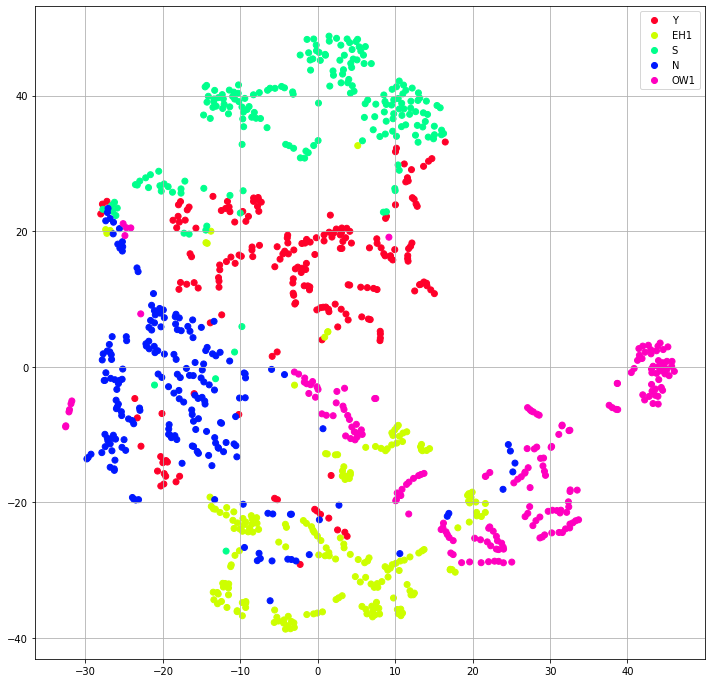

In [24]:
plt.figure(figsize=(12, 12))
scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='gist_rainbow')
plt.legend(handles=scatter.legend_elements()[0], labels=PHONEMES)
plt.grid()
plt.show()

Действительно, фонемы делятся на некоторые кластеры, которые слегка пересекаются друг с другом

### <b>Задание №2</b> (5 баллов):
Заменить модель среднего значения фонемы на GMM. Количестов смесей для каждой фонемы можно выставить в 3. Теперь вместо расстояния мы будем измерять вероятность принадлежности кадра признаков к GMM модели фонемы, находящейся в конкретном узле графа. Чтобы использовать это значение в парадигме нашего алгоритма, в качестве дистанции нужно брать значение -log(x), где x -- предсказанная вероятность. Тогда чем выше вероятность, тем такая импровизированная дистанция будет меньше. Ссылка на питоновскую реализацию GMM -- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html.

Что стало с качеством распознавания на двух тестах?

### **Ответ**:

In [25]:
def load_graph_gmm(lexicon_dict, gmm_phones_value, covariance_type='full'):
    start_state = State(GmmAcousticModel(None, None, covariance_type), 0)
    graph = [start_state,]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(GmmAcousticModel(phone, gmm_phones_value[phone], covariance_type), state_index)
            state.current_word = word
            state.next_states.append(state)
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [26]:
phones_dict = init_phones_dict(phones_file)
train_data_dict = load_data_dict(train_records_dir, count=100)

for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])

0it [00:00, ?it/s]

Early stop at 100th file..


Yes/No, GMM с обычной матрицей ковариации

In [27]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph_gmm(lexicon_dict, phones_dict, covariance_type='full')
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=100)

0it [00:00, ?it/s]

result: no_4abb2400_nohash_0        ==> YES
result: yes_39a12648_nohash_0       ==> NO
result: no_49af4432_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.36 sec
------------------------------------------------------------


Yes/No, GMM с диагональной матрицей ковариации

In [28]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph_gmm(lexicon_dict, phones_dict, covariance_type='diag')
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=100)

0it [00:00, ?it/s]

result: no_4abb2400_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.04 sec
------------------------------------------------------------


Digits, GMM с обычной матрицей ковариации

In [29]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph_gmm(lexicon_dict, phones_dict, covariance_type='full')
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=100)

0it [00:00, ?it/s]

result: five_ffd2ba2f_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> TWO
result: five_f852895b_nohash_0      ==> FIVE
result: nine_ccea893d_nohash_0      ==> SEVEN
result: four_ffbb695d_nohash_0      ==> FOUR
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: three_feb1d305_nohash_0     ==> SIX
result: one_fc2411fe_nohash_0       ==> NINE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: two_fce65496_nohash_0       ==> SIX
result: eight_da584bc0_nohash_4     ==> SIX
result: three_fce96bac_nohash_0     ==> SIX
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_fce65496_nohash_0      ==> FOUR
result: six_ffd2ba2f_nohash_0       ==> SIX
result: nine_fbe51750_nohash_0      ==> NINE
result: eight_daf230ac_nohash_0     ==> SIX
result: zero_f92e49f3_nohash_3      ==> SIX
result: six_ffbb695d_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> FIVE
------------------------------------------------------------
WER is: 45.00%
Total time is: 24.03 sec
------

Digits, GMM с диагональной матрицей ковариации

In [30]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph_gmm(lexicon_dict, phones_dict, covariance_type='diag')
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=100)

0it [00:00, ?it/s]

result: five_ffd2ba2f_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> SIX
result: five_f852895b_nohash_0      ==> FIVE
result: nine_ccea893d_nohash_0      ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: three_feb1d305_nohash_0     ==> THREE
result: one_fc2411fe_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: two_fce65496_nohash_0       ==> EIGHT
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_fce96bac_nohash_0     ==> THREE
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_fce65496_nohash_0      ==> FOUR
result: six_ffd2ba2f_nohash_0       ==> SIX
result: nine_fbe51750_nohash_0      ==> NINE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: zero_f92e49f3_nohash_3      ==> ZERO
result: six_ffbb695d_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> ZERO
------------------------------------------------------------
WER is: 10.00%
Total time is: 20.18 s

При переходе на GMM с обычной матрицей ковариации качество незначительно выросло, при переходе на GMM с диагональной матрицей ковариации качество выросло значительно. Также GMM с диагональной матрицей ковариации работает быстрее, чем GMM с обычной